## Introduction:
Cryptocurrencies have gained significant attention in recent years as an alternative investment and a revolutionary digital asset class. The volatile nature of cryptocurrency prices presents both opportunities and challenges for traders and investors. To make informed decisions and develop effective trading strategies, it is crucial to analyze historical price data and forecast future price movements.

In this notebook, we will perform an exploratory data analysis (EDA) on a dataset containing historical price information for various cryptocurrencies. We will visualize the price trends, identify patterns, and explore the relationships between different variables. The dataset includes columns such as 'Crypto', 'Date', 'Open', 'High', 'Low', 'Close', and additional features like 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', and 'Season'.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from statsmodels.tsa.arima.model import ARIMA

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cryptocurrency-price-analysis-dataset/ETH.csv
/kaggle/input/cryptocurrency-price-analysis-dataset/XPR.csv
/kaggle/input/cryptocurrency-price-analysis-dataset/crypto_combine.csv
/kaggle/input/cryptocurrency-price-analysis-dataset/BTC.csv
/kaggle/input/cryptocurrency-price-analysis-dataset/LTC.csv


In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/cryptocurrency-price-analysis-dataset/crypto_combine.csv")

## Data Exploration

In [4]:
# Display the first few rows of the dataset
df.head()

,Crypto,Date,Open,High,Low,Close
0,BTC,12/31/19,7254.0,7309.0,7132.0,7171.0
1,BTC,12/30/19,7402.0,7430.0,7217.0,7254.0
2,BTC,12/29/19,7334.0,7529.0,7295.0,7402.0
3,BTC,12/28/19,7235.0,7359.0,7235.0,7334.0
4,BTC,12/27/19,7208.0,7267.0,7087.0,7235.0


In [5]:
# Get summary statistics of the dataset
df.describe()

,Open,High,Low,Close
count,7899.000000,7899.000000,7899.000000,7899.000000
mean,5479.620176,5623.947143,5324.149024,5480.870398
std,12010.579332,12325.039614,11665.236339,12011.567525
min,0.140000,0.150000,0.120000,0.140000
25%,12.720000,13.410000,12.405000,12.680000
50%,170.910000,176.240000,163.320000,170.890000
75%,3879.000000,3962.000000,3757.000000,3878.935000
max,67802.000000,68925.000000,66112.000000,67802.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7899 entries, 0 to 7898
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Crypto  7899 non-null   object 
 1   Date    7899 non-null   object 
 2   Open    7899 non-null   float64
 3   High    7899 non-null   float64
 4   Low     7899 non-null   float64
 5   Close   7899 non-null   float64
dtypes: float64(4), object(2)
memory usage: 370.4+ KB


## Feature Engineering

1. 'Year': Extracted the year from the 'Date' column.
1. 'Month': Extracted the month from the 'Date' column.
1. 'Day': Extracted the day of the month from the 'Date' column.
1. 'DayOfWeek': Extracted the day of the week from the 'Date' column (0 - Monday, 6 - Sunday).
1. 'Quarter': Extracted the quarter of the year from the 'Date' column.
1. 'Season': Created a new column 'Season' based on the month using a custom function.

In [7]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Extract year, month, day, day of the week, quarter, and season as new features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function to create a new 'Season' column
df['Season'] = df['Month'].apply(get_season)

In [8]:
df.head(10)

,Crypto,Date,Open,High,Low,Close,Year,Month,Day,DayOfWeek,Quarter,Season
7533,XRP,2018-01-01,1.99,2.10,1.82,2.10,2018,1,1,0,1,Winter
5558,LTC,2018-01-01,230.32,237.77,217.87,225.63,2018,1,1,0,1,Winter
3583,ETH,2018-01-01,744.39,772.98,725.10,757.01,2018,1,1,0,1,Winter
729,BTC,2018-01-01,13996.00,14035.00,12860.00,13535.00,2018,1,1,0,1,Winter
728,BTC,2018-01-02,13535.00,15217.00,12956.00,14770.00,2018,1,2,1,1,Winter
7532,XRP,2018-01-02,2.07,2.22,1.93,2.21,2018,1,2,1,1,Winter
5557,LTC,2018-01-02,225.34,265.00,225.01,254.60,2018,1,2,1,1,Winter
3582,ETH,2018-01-02,758.00,879.90,757.01,864.00,2018,1,2,1,1,Winter
3581,ETH,2018-01-03,861.99,947.92,851.00,938.00,2018,1,3,2,1,Winter
7531,XRP,2018-01-03,2.20,2.90,2.19,2.78,2018,1,3,2,1,Winter


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7899 entries, 7533 to 4314
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Crypto     7899 non-null   object        
 1   Date       7899 non-null   datetime64[ns]
 2   Open       7899 non-null   float64       
 3   High       7899 non-null   float64       
 4   Low        7899 non-null   float64       
 5   Close      7899 non-null   float64       
 6   Year       7899 non-null   int64         
 7   Month      7899 non-null   int64         
 8   Day        7899 non-null   int64         
 9   DayOfWeek  7899 non-null   int64         
 10  Quarter    7899 non-null   int64         
 11  Season     7899 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 802.2+ KB


## Exploratory Data Analysis

In [10]:
# Summary statistics
numeric_cols = ['Open', 'High', 'Low', 'Close']
summary_stats = df[numeric_cols].describe()
print(summary_stats)

               Open          High           Low         Close
count   7899.000000   7899.000000   7899.000000   7899.000000
mean    5479.620176   5623.947143   5324.149024   5480.870398
std    12010.579332  12325.039614  11665.236339  12011.567525
min        0.140000      0.150000      0.120000      0.140000
25%       12.720000     13.410000     12.405000     12.680000
50%      170.910000    176.240000    163.320000    170.890000
75%     3879.000000   3962.000000   3757.000000   3878.935000
max    67802.000000  68925.000000  66112.000000  67802.000000


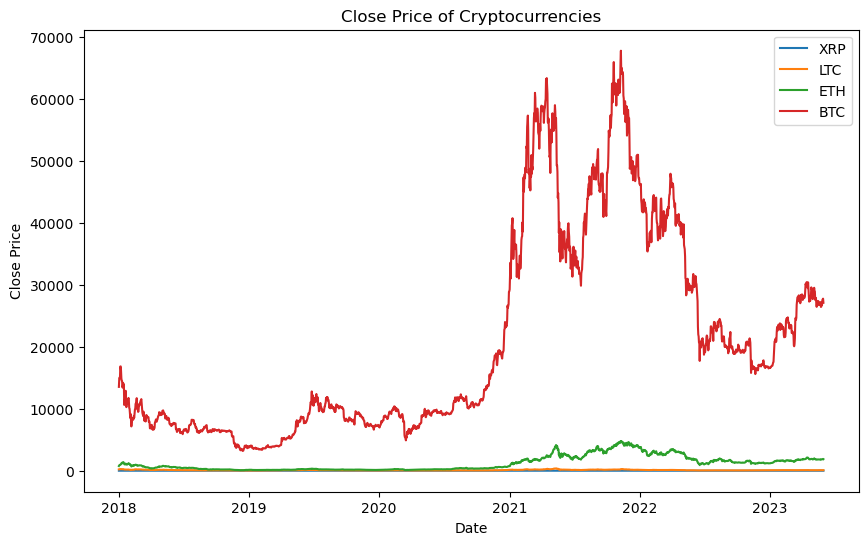

In [11]:
# Line chart for 'Close' price over time
crypto_list = df['Crypto'].unique()
plt.figure(figsize=(10, 6))
for crypto in crypto_list:
    crypto_df = df[df['Crypto'] == crypto]
    plt.plot(crypto_df['Date'], crypto_df['Close'], label=crypto)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price of Cryptocurrencies')
plt.legend()
plt.show()

In [12]:
# Line chart for 'Close' price over time (interactive)
fig = px.line(df, x='Date', y='Close', color='Crypto', title='Close Price of Cryptocurrencies')
fig.update_layout(xaxis_title='Date', yaxis_title='Close Price')
fig.show()

In [13]:
# Group the DataFrame by 'Crypto' column
grouped_df = df.groupby('Crypto')

# Create an interactive line chart for each cryptocurrency
figs = []
for crypto, crypto_df in grouped_df:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=crypto_df['Date'], y=crypto_df['Close'], name=crypto))
    fig.update_layout(title=f"Close Price of {crypto}")
    fig.update_xaxes(title='Date')
    fig.update_yaxes(title='Close Price')
    figs.append(fig)

# Display the charts
for fig in figs:
    fig.show()

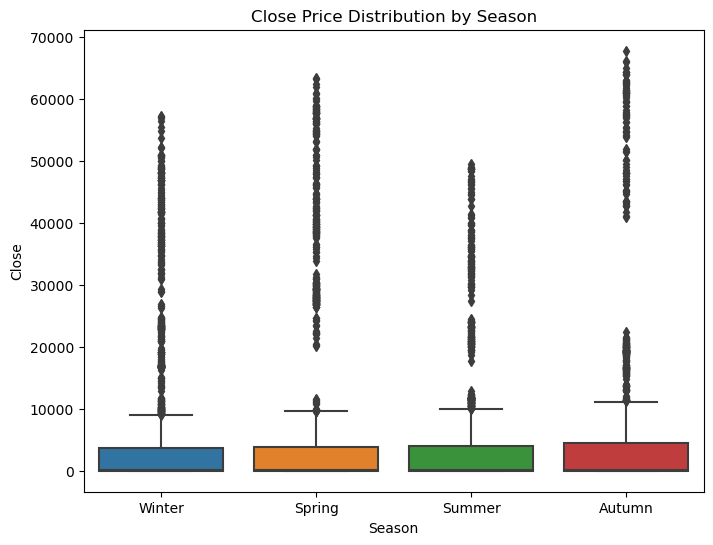

In [14]:
# Box plot for 'Close' price by season
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Season', y='Close')
plt.title('Close Price Distribution by Season')
plt.show()

Scale the data as a change from the initial data.

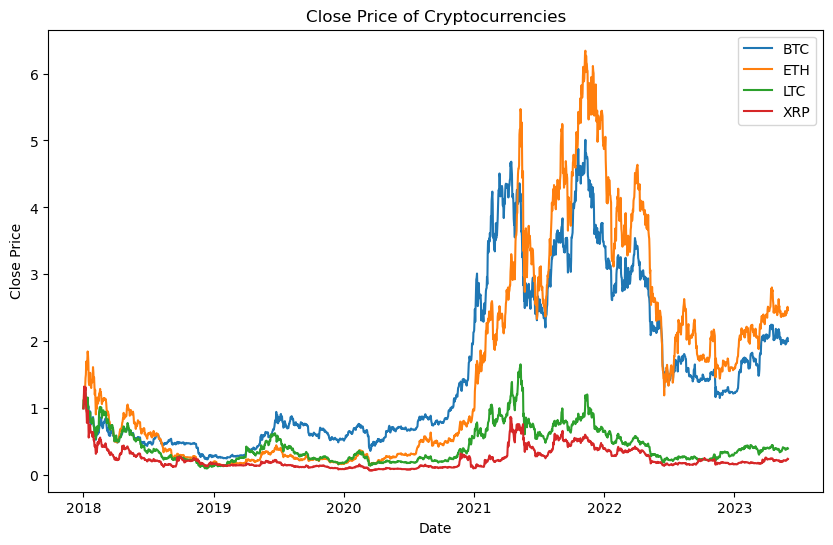

In [15]:
close_columns = ['Date', 'Crypto', 'Close']
close_df = df[close_columns].sort_values(by=['Date', 'Crypto']).reset_index(drop=True)
currencies = sorted(close_df['Crypto'].unique().tolist())

def get_scaled(currency: str, arg_df: pd.DataFrame) -> pd.DataFrame:
    result_df = arg_df[arg_df['Crypto'] == currency].copy(deep=True)
    min_date = result_df['Date'].min()
    result_df['Close'] = result_df['Close'].astype(float)
    scale_value = result_df[result_df['Date'] == min_date]['Close'].astype(float)
    result_df['Close'] = result_df['Close'].apply(func=lambda x: x/scale_value) 
    return result_df

scaled_df = pd.concat([get_scaled(currency=currency, arg_df=close_df) for currency in currencies]).sort_values(by=['Date', 'Crypto']).reset_index(drop=True)

plt.figure(figsize=(10, 6))
for currency in currencies:
    crypto_df = scaled_df[scaled_df['Crypto'] == currency]
    plt.plot(crypto_df['Date'], crypto_df['Close'], label=currency)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price of Cryptocurrencies')
plt.legend()
plt.show()

We can add a trendline easily using the Seaborn lmplot, but we need to change the dates to sensible floats first.

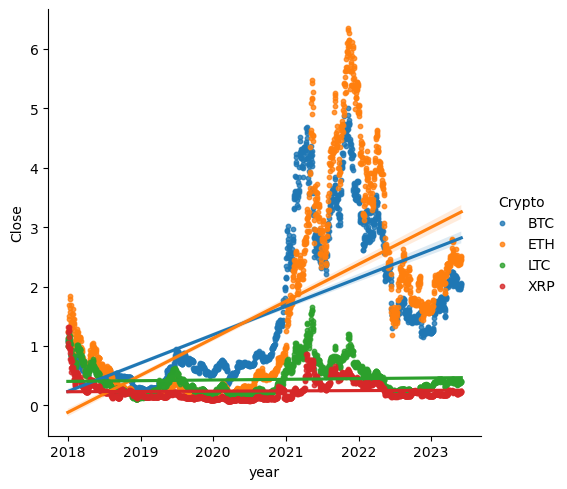

In [16]:
from seaborn import lmplot
min_date = scaled_df['Date'].min()
scaled_df['year'] = scaled_df['Date'].apply(lambda x: 2018 + (x - min_date).days/365)
lmplot(data=scaled_df, x='year', y='Close', hue='Crypto', scatter_kws={'s': 10,},)

The trend lines look very different if we start in 2021

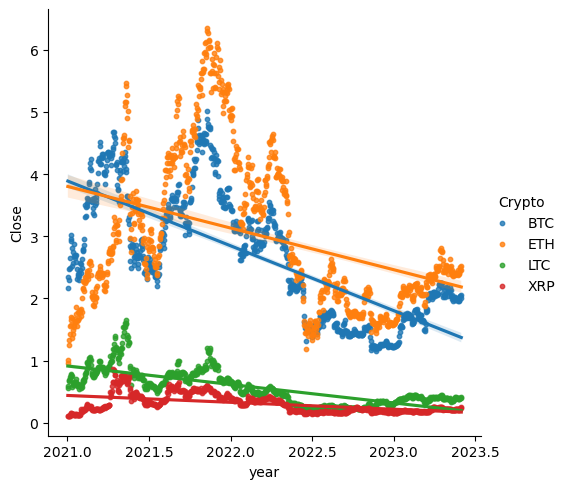

In [17]:
lmplot(data=scaled_df[scaled_df['year'] > 2021], x='year', y='Close', hue='Crypto', scatter_kws={'s': 10,},)